Relative L2(n)  over spacetime = 7.939088e-03
Relative L2(J0) over spacetime = 8.313314e-03
[saved] /Users/faridchomali/Desktop/BDNK/Current KT Codes (use JIT)/L2/test3b/L2_results.txt


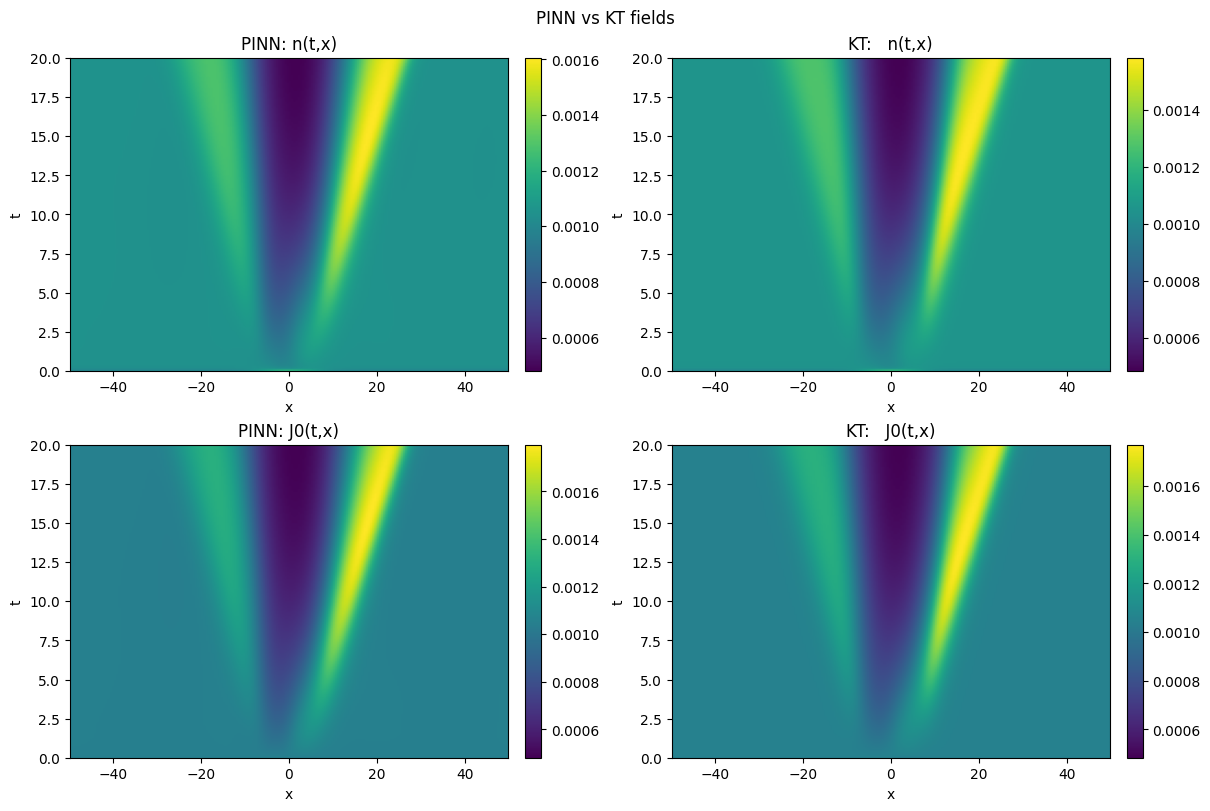

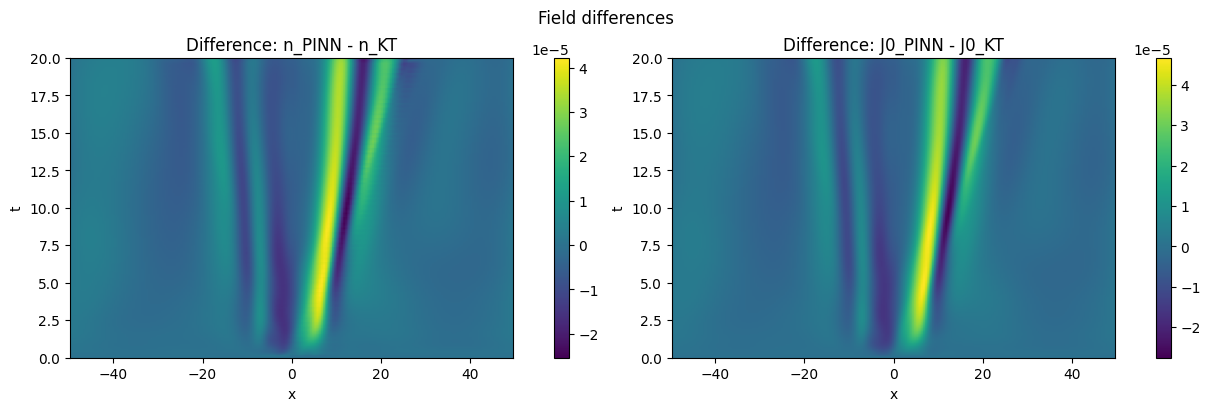

[saved] /Users/faridchomali/Desktop/BDNK/Current KT Codes (use JIT)/L2/test3b/PINN_vs_KT.png
[saved] /Users/faridchomali/Desktop/BDNK/Current KT Codes (use JIT)/L2/test3b/Field_differences.png


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---- Load data ----
try:
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    base_dir = os.getcwd()

folder = os.path.join(base_dir, "test3b")

pinn_path = os.path.join(folder, "pinn_data.npz")
kt_path   = os.path.join(folder, "kt_data.npz")

pinn = np.load(pinn_path, allow_pickle=True)
kt   = np.load(kt_path,   allow_pickle=True)

# --- Grids ---
t_eval_p = pinn["t_eval"].astype(np.float64)
x_eval_p = pinn["x_eval"].astype(np.float64)
t_eval_k = kt["t_eval"].astype(np.float64)
x_eval_k = kt["x_eval"].astype(np.float64)

# --- Directly loaded fields ---
n_pinn  = pinn["n_grid"].astype(np.float64)
J0_pinn = pinn["J0_grid"].astype(np.float64)
n_kt    = kt["n_grid"].astype(np.float64)
J0_kt   = kt["J0_grid"].astype(np.float64)

# --- Domain size (for periodic interp) ---
L = float(kt.get("L", pinn.get("L", 50.0)))

# --- If grids differ, remap KT → PINN grid ---
def periodic_interp_space_vec(x_src, Ytx, x_q, L):
    x_ext = np.concatenate([x_src - 2*L, x_src, x_src + 2*L])
    out = np.empty((Ytx.shape[0], x_q.size), dtype=np.float64)
    xq = ((x_q + L) % (2*L)) - L
    for it in range(Ytx.shape[0]):
        y_ext = np.concatenate([Ytx[it], Ytx[it], Ytx[it]])
        out[it] = np.interp(xq, x_ext, y_ext)
    return out

def interp_time_vec(t_src, Ytx, t_q):
    Nt_q, Nx = t_q.size, Ytx.shape[1]
    out = np.empty((Nt_q, Nx), dtype=np.float64)
    for j in range(Nx):
        out[:, j] = np.interp(t_q, t_src, Ytx[:, j])
    return out

def remap_to_grid(t_src, x_src, Ytx, t_dst, x_dst, L):
    Y_t = interp_time_vec(t_src, Ytx, t_dst)
    Y_x = periodic_interp_space_vec(x_src, Y_t, x_dst, L)
    return Y_x

if (not np.allclose(t_eval_k, t_eval_p)) or (not np.allclose(x_eval_k, x_eval_p)):
    n_kt_on_p  = remap_to_grid(t_eval_k, x_eval_k, n_kt,  t_eval_p, x_eval_p, L)
    J0_kt_on_p = remap_to_grid(t_eval_k, x_eval_k, J0_kt, t_eval_p, x_eval_p, L)
else:
    n_kt_on_p  = n_kt
    J0_kt_on_p = J0_kt

# --- Relative L2 errors over spacetime (weighted by dt * dx) ---
dx = (x_eval_p[-1] - x_eval_p[0]) / (x_eval_p.size - 1)
dt = (t_eval_p[-1] - t_eval_p[0]) / (t_eval_p.size - 1)

def rel_l2(phi_pinn, phi_kt, dx, dt):
    num = np.sqrt(np.sum((phi_pinn - phi_kt)**2) * dx * dt)
    den = np.sqrt(np.sum((phi_kt)**2) * dx * dt)
    return 0.0 if den == 0.0 else num / den

Erel_n  = rel_l2(n_pinn,  n_kt_on_p,  dx, dt)
Erel_J0 = rel_l2(J0_pinn, J0_kt_on_p, dx, dt)

print(f"Relative L2(n)  over spacetime = {Erel_n:.6e}")
print(f"Relative L2(J0) over spacetime = {Erel_J0:.6e}")

# --- Save text report ---
report_path = os.path.join(folder, "L2_results.txt")
with open(report_path, "w") as f:
    f.write(f"Relative L2(n)  over spacetime = {Erel_n:.6e}\n")
    f.write(f"Relative L2(J0) over spacetime = {Erel_J0:.6e}\n")
print(f"[saved] {report_path}")

# --- Visualization helpers ---
def heat(ax, Z, title, t_axis, x_axis):
    im = ax.imshow(
        Z, origin="lower",
        extent=[x_axis[0], x_axis[-1], t_axis[0], t_axis[-1]],
        aspect="auto",
    )
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# --- Plots ---
fig1, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
heat(axs[0,0], n_pinn,        "PINN: n(t,x)",  t_eval_p, x_eval_p)
heat(axs[0,1], n_kt_on_p,     "KT:   n(t,x)",  t_eval_p, x_eval_p)
heat(axs[1,0], J0_pinn,       "PINN: J0(t,x)", t_eval_p, x_eval_p)
heat(axs[1,1], J0_kt_on_p,    "KT:   J0(t,x)", t_eval_p, x_eval_p)
plt.suptitle("PINN vs KT fields")
fig1_path = os.path.join(folder, "PINN_vs_KT.png")
plt.savefig(fig1_path, dpi=300)
plt.show()

fig2, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
heat(axs[0], n_pinn - n_kt_on_p,  "Difference: n_PINN - n_KT",  t_eval_p, x_eval_p)
heat(axs[1], J0_pinn - J0_kt_on_p, "Difference: J0_PINN - J0_KT", t_eval_p, x_eval_p)
plt.suptitle("Field differences")
fig2_path = os.path.join(folder, "Field_differences.png")
plt.savefig(fig2_path, dpi=300)
plt.show()

print(f"[saved] {fig1_path}")
print(f"[saved] {fig2_path}")
